In [1]:
# make data frame from csv file
import pandas as pd
df = pd.read_csv('emails.csv', encoding="ISO-8859-1")

In [2]:
df.tail()

,text,spam
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0
5727,Subject: news : aurora 5 . 2 update aurora ve...,0


In [3]:
# divide data into text and its label
from sklearn.model_selection import train_test_split
text = df['text'].values
label = df['spam'].values
# divide data into data train and data test
text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.2)

In [4]:
# show sample of the email
print(text_train[0])
print('\n')
print(text_test[0])

Subject: fwd : hea renewals & crawfish boil teaser  shirley ,  please , enroll me in this organization .  vince  - - - - - - - - - - - - - - - - - - - - - - forwarded by vince j kaminski / hou / ect on 04 / 04 / 2000  10 : 11 am - - - - - - - - - - - - - - - - - - - - - - - - - - -  jlpnymex @ aol . com on 03 / 22 / 2000 04 : 24 : 33 pm  to : nalexander @ texasmonthly . emmis . com , blackj @ wellsfargo . com ,  rdyerlaw @ houston . rr . com , sgoldfield @ tmh . tmc . edu , ggulen @ uh . edu ,  lesley . guthrie @ cpa . state . tx . us , elizabethherring @ pzlqs . com ,  robyn _ howard @ aimfunds . com , vkamins @ enron . com , mmfoss @ uh . edu ,  adrian . a . nunez @ usa . conoco . com , jack _ plunkett @ plunkettresearch . com ,  james . stanton @ et . pge . com , dstowers @ watersinfo . com , woodybc @ bp . com  cc :  subject : fwd : hea renewals tue , 21 mar 2000 17 : 20 : 25 - 0500  received : from cobaltl . crescentcon . com ( cobaltl . crescentcon . com  [ 208 . 244 . 126 . 12 ]

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# convert each word into certain number (tokenization) 
tokenizer = Tokenizer(num_words=10000, oov_token='*', 
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
                      split=' ', char_level=False)
tokenizer.fit_on_texts(text_train) 
tokenizer.fit_on_texts(text_test)
# convert each text into sequence
sequence_train = tokenizer.texts_to_sequences(text_train)
sequence_test = tokenizer.texts_to_sequences(text_test)

In [6]:
# show sample of the token
print(tokenizer.texts_to_sequences(text_train[0]))
print('\n')
print(tokenizer.texts_to_sequences(text_test[0]))

[[30], [415], [314], [48], [72], [292], [102], [], [], [778], [470], [184], [], [], [], [756], [72], [6], [], [367], [72], [828], [72], [470], [6], [339], [30], [], [], [], [292], [367], [6], [470], [778], [9], [30], [756], [], [314], [390], [9], [339], [], [102], [72], [6], [30], [72], [367], [], [], [30], [756], [9], [367], [339], [72], [1321], [], [], [], [], [203], [339], [72], [6], [30], [72], [], [], [], [72], [828], [367], [390], [339], [339], [], [125], [72], [], [9], [828], [], [102], [756], [9], [30], [], [390], [367], [382], [6], [828], [9], [2215], [6], [102], [9], [390], [828], [], [], [], [], [524], [9], [828], [292], [72], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [778], [390], [367], [470], [6], [367], [184], [72], [184], [], [314], [1321], [], [524], [9], [828], [292], [72], [], [48], [], [584], [6], [125], [9], [828], [30], [584

In [7]:
# implement padding to the text
padded_train = pad_sequences(sequence_train,
                            padding='post',
                            maxlen=50,
                            truncating='post') 
padded_test = pad_sequences(sequence_test,
                            padding='post',
                            maxlen=50,
                            truncating='post')

In [8]:
# show the sample of the padded text
print(padded_train[0])
print('\n')
print(padded_test[0])

[  16 1664 4108 7560    1    1    1  106   38 3837   43    8   17  860
   23  123   33   23   48   40   32   14   12  121  121   39   60   99
   37 6075  620   34   12  140  351   39  121  315  786   52    3    1
    1    1   34    1    1   34    1  116]


[  16 4290 1636  506  357  410  238 4568    9  511   18    2 2415   29
 4329 6349   17   38  128 4877  235  275  410  461   94   44 3103  494
    3   20 3641   26    2 1945    9   25  131 5822    2   54   65  205
  117  333    2 4066 9464 1013  357   13]


In [9]:
# make machine learning model
import tensorflow as tf
from tensorflow.keras import regularizers
model = tf.keras.Sequential([
  # implement embedding
  tf.keras.layers.Embedding(10000, 64), 
  # use 2 layer of bidirectional LSTM
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation='relu',
                        kernel_regularizer=regularizers.l2(0.00001)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation='relu',
                        kernel_regularizer=regularizers.l2(0.00001)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
# implement dropout and regularizers function

In [10]:
# use adam optimizer and binary crossentropy loss function
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
# implement callback when the accuracy > 90%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print("\nAccuracy has been >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [12]:
# train the model
num_epochs = 100
history = model.fit(padded_train, label_train, epochs=num_epochs, batch_size=512,
                    callbacks=[callbacks], validation_data=(padded_test, label_test), verbose=2)

Epoch 1/100
9/9 - 17s - 2s/step - accuracy: 0.7268 - loss: 0.6042 - val_accuracy: 0.7504 - val_loss: 0.5022
Epoch 2/100
9/9 - 7s - 784ms/step - accuracy: 0.7639 - loss: 0.3769 - val_accuracy: 0.7504 - val_loss: 0.2579
Epoch 3/100
9/9 - 8s - 900ms/step - accuracy: 0.8769 - loss: 0.2114 - val_accuracy: 0.9747 - val_loss: 0.1423
Epoch 4/100

Accuracy has been >90%!
9/9 - 5s - 538ms/step - accuracy: 0.9712 - loss: 0.1008 - val_accuracy: 0.9651 - val_loss: 0.0987


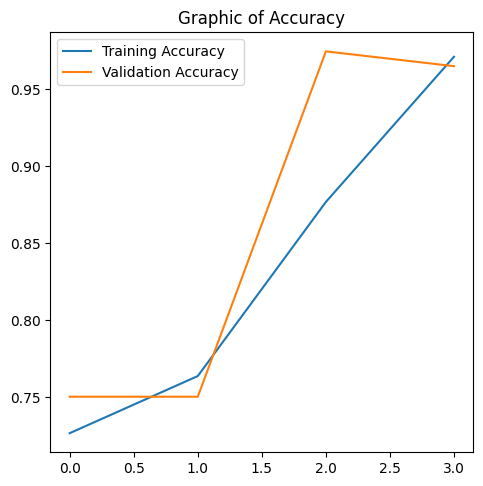

In [13]:
# show graphic plot of accuracy
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 3)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Graphic of Accuracy')
plt.show()

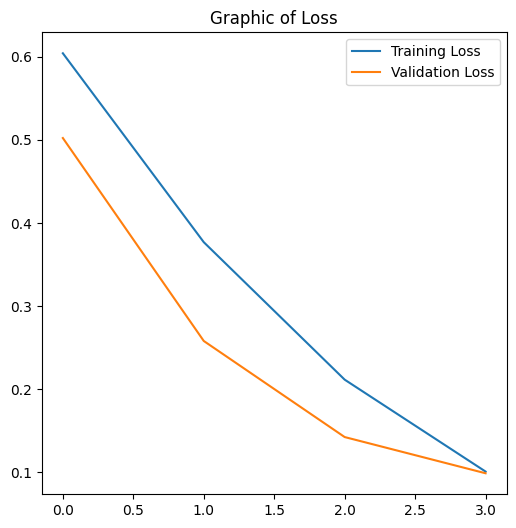

In [14]:
# show graphic plot of loss
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Graphic of Loss')
plt.show()

In [15]:
# test the model using sample of spam email from my inbox
spam_text = """
When you toss a pebble in a pond, outward ripples result. Make that pebble a stone, and the ripples are larger, stronger and extend further. If the ripples are the results of your organization, your frontline leaders are stones, not pebbles.
 
Everyone will say that frontline leaders are important to the success of their organizations. But most don’t know just how true that is.
 
If you want your organization to be more effective, productive, and resilient you need to think more about how you engage, support, and invest in your Frontline leaders.
 
Join Kevin Eikenberry, a leading authority on leadership and leadership development for this informative, engaging, interactive, and thought-provoking webinar to better understand the leverage your frontline leaders have on nearly all aspects of organizational success. More importantly you will leave with an action plan for how you can create more of the results you desire.
 
If you are looking to jumpstart the development of your leaders, or are stymied by your past efforts, this will be worth your time.
 
By the end of this engaging and dynamic session, you will be able to:
Describe the underlying reasons why frontline leaders are such a leverage point for organizational success.
How to create a learning culture for your frontline leaders
Identify approaches to developing frontline leaders – and determine the best for your situations
Build an action plan to improve the skills and results of your frontline leaders
The future is bright for organizations with prepared, skilled, and confident frontline leaders. Join us to think about and build a plan for helping your frontline leaders drive our organizational success.
 
Learn more and register here!
"""
tokenizer.fit_on_texts(spam_text)
spam_sequence = tokenizer.texts_to_sequences(spam_text)
spam_padded = pad_sequences(spam_sequence,
                            padding='post',
                            maxlen=50,
                            truncating='post')
prediction = model.predict(spam_padded)
result = sum(prediction)/len(prediction)
if result > 0.6:
    print("The email is spam")
else:
    print("The email is not spam")

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
The email is spam
